# OpenJijにおける相互作用行列の保持の仕方
解きたい問題によって、イジングハミルトニアンの相互作用行列$J$やQUBOの相互作用行列$Q$に含まれる非ゼロの要素数は大きく変化します。
実問題の多くでは、相互作用行列の中の非ゼロの要素数は比較的少なく疎な行列であることが多いです。
そこで、OpenJijでは、デフォルトでは内部で相互作用係数を疎行列として保持するようになっています。
ですが、解きたい問題によっては必ずしも疎行列であるというわけではありません。
この場合には、疎行列形式のデータ保持では計算速度が低下してしまいます。
この点を解決するために、OpenJijは、ユーザーが自分で行列保持の仕方を制御できるパラメータである`sparse`が用意されています。
このチュートリアルでは、この`sparse`の使い方を説明し、疎行列でデータを保持した場合と密行列でデータを保持した場合の速度を比較してみます。


In [1]:
import openjij as oj
import numpy as np
import time

データの内部保持の仕方は、次のように設定することができます。
```python
sampler = oj.SASampler()
response = sampler.sample_ising(h, J, sparse = True)
```
ここで、`sparse = True`とすると内部の相互作用行列のデータ保持の仕方が疎行列になります。現在のOpenJijでは、デフォルトで`sparse = True`となっています。
このフラグを
```python
response = sampler.sample_ising(h, J, sparse = False)
```
のようにすると、内部でのデータ保持の仕方を密行列にすることができます。

## sparseモードとdenseモードでの実行速度の比較
次に、データ保持の仕方を変化することで実行速度にどのように違いが出るかを検証してみます。

In [2]:
NUM_READS = 1

BETA_MAX = 14000000
BETA_MIN = 0.0015

num_spins = [100,200,500,1000,2000,5000]
p_list = [0.1,0.3,0.5,0.8]

ここでは、外場のないSherrington-Kirkpatrick模型を変形させた用いてベンチマークを取りたいと思います、
外場のないSherrington-Kirkpatrick(SK)模型は、次のようなハミルトニアンを持つ模型です。

$$ H = \frac{1}{N}\sum_{ij} J_{ij} \sigma_i \sigma_j,\\ \ J_{ij} \sim \mathcal{N}(0,1), J_{ij} = J_{ji}$$

ここで、$\mathcal{N}(0,1)$は平均0、分散1のランダムガウスノイズです。
SK模型では全ての要素がランダム分布に従っていますが、ここでは、相互作用行列$J$に入っている要素の割合を変化させていき、相互作用を疎にしていくことで、計算時間がどのように変化するかを調べます。

まず、初めにランダムな相互作用を作ります。ここで、パラメータはスピン数$n$と相互作用行列$J$に入っている要素の割合$p$です。

In [6]:
def create_random_interaction(n,p):
    h,J = {},{}
    for i in range(n-1):
        for j in range(i+1, n):
            if np.random.random() <= p:
                # OpenJijでは、上三角行列の形でデータを保持している。
                J[i, j] = np.random.normal(0, 1) / np.sqrt(n)

    return J,h

最初に密行列を用いた場合を計算してみます。
ここでは、スピン数を$n=100,200,500,1000,2000,5000$と変化させ、相互作用行列$J$に入っている要素の割合$p$も$p=0.1,0.3,0.5,0.8$と変化させます。

In [7]:
# Benchmark OpenJij Dense
print('OpenJij Dense')
sampler = oj.SASampler()
openjij_dense_time = []
openjij_dense_energy = []

for p in p_list:
    for n in num_spins:
        J,h = create_random_interaction(n,p)
        start = time.perf_counter()
        response = sampler.sample_ising(h, J, num_sweeps=1000, num_reads=NUM_READS, beta_max=BETA_MAX, beta_min=BETA_MIN,sparse = False)
        elapsed_time = time.perf_counter() - start

        openjij_dense_time.append(elapsed_time)
        openjij_dense_energy.append(np.mean(response.energies))

        print(f"p = {p}, n = {n} : \telapsed_time:{elapsed_time}[sec]")

OpenJij Dense
p = 0.1, n = 100 : 	elapsed_time:0.02439586600007715[sec]
p = 0.1, n = 200 : 	elapsed_time:0.04425178099995719[sec]
p = 0.1, n = 500 : 	elapsed_time:0.07739514899992628[sec]
p = 0.1, n = 1000 : 	elapsed_time:0.2425712609999664[sec]
p = 0.1, n = 2000 : 	elapsed_time:1.6797769239999525[sec]
p = 0.1, n = 5000 : 	elapsed_time:13.506819940000014[sec]
p = 0.3, n = 100 : 	elapsed_time:0.006876676999922893[sec]
p = 0.3, n = 200 : 	elapsed_time:0.0159878800000115[sec]
p = 0.3, n = 500 : 	elapsed_time:0.07934188900003392[sec]
p = 0.3, n = 1000 : 	elapsed_time:0.3215275050000628[sec]
p = 0.3, n = 2000 : 	elapsed_time:2.319988950000038[sec]
p = 0.3, n = 5000 : 	elapsed_time:15.02982138099992[sec]
p = 0.5, n = 100 : 	elapsed_time:0.007885184999963712[sec]
p = 0.5, n = 200 : 	elapsed_time:0.020288821000008284[sec]
p = 0.5, n = 500 : 	elapsed_time:0.10879908200001864[sec]
p = 0.5, n = 1000 : 	elapsed_time:0.41148077200000444[sec]
p = 0.5, n = 2000 : 	elapsed_time:2.1696542160000263[sec]

次に、疎行列を用いた場合を検証します。実行条件は密行列の場合と同様です。

In [9]:
# Benchmark OpenJij Sparse
print('OpenJij Sparse')
sampler = oj.SASampler()
openjij_sparse_time = []
openjij_sparse_energy = []
for p in p_list:
    for n in num_spins:
        J,h = create_random_interaction(n,p)
        start = time.perf_counter()
        response = sampler.sample_ising(h, J, num_sweeps=1000, num_reads=NUM_READS, beta_max=BETA_MAX, beta_min=BETA_MIN, sparse=True)
        elapsed_time = time.perf_counter() - start

        openjij_sparse_time.append(elapsed_time)
        openjij_sparse_energy.append(np.mean(response.energies))

        print(f"p = {p}, n = {n} : \telapsed_time:{elapsed_time}[sec]")

OpenJij Sparse
p = 0.1, n = 100 : 	elapsed_time:0.018858227999999144[sec]
p = 0.1, n = 200 : 	elapsed_time:0.011375076999911471[sec]
p = 0.1, n = 500 : 	elapsed_time:0.040720876000023054[sec]
p = 0.1, n = 1000 : 	elapsed_time:0.1434848740000234[sec]
p = 0.1, n = 2000 : 	elapsed_time:0.5859196809999503[sec]
p = 0.1, n = 5000 : 	elapsed_time:4.693539175000069[sec]
p = 0.3, n = 100 : 	elapsed_time:0.008090091999974902[sec]
p = 0.3, n = 200 : 	elapsed_time:0.01928631900000255[sec]
p = 0.3, n = 500 : 	elapsed_time:0.09923592899986033[sec]
p = 0.3, n = 1000 : 	elapsed_time:0.3975637910000387[sec]
p = 0.3, n = 2000 : 	elapsed_time:1.9902634820000458[sec]
p = 0.3, n = 5000 : 	elapsed_time:14.41226490400004[sec]
p = 0.5, n = 100 : 	elapsed_time:0.010653709000052913[sec]
p = 0.5, n = 200 : 	elapsed_time:0.02600566599994636[sec]
p = 0.5, n = 500 : 	elapsed_time:0.16183085200009373[sec]
p = 0.5, n = 1000 : 	elapsed_time:0.6748764890000984[sec]
p = 0.5, n = 2000 : 	elapsed_time:3.276416020999932[se

密行列と疎行列の場合で得られた結果を比較するために、プロットしてみます。

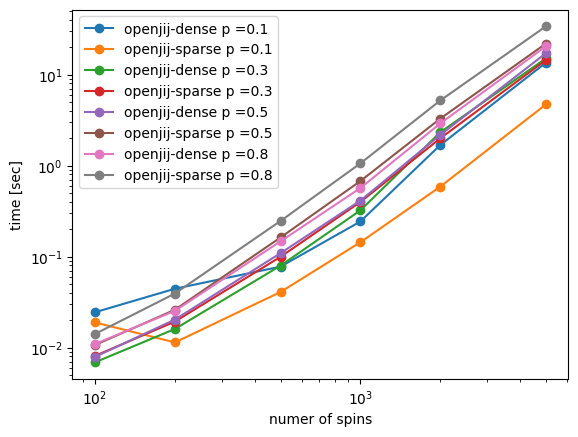

In [10]:
import matplotlib.pyplot as plt
sparse_time = np.array(openjij_sparse_time).reshape(len(p_list),-1)
dense_time = np.array(openjij_dense_time).reshape(len(p_list),-1)
for index,p in enumerate(p_list):
    plt.plot(num_spins,dense_time[index], '-o', label=f'openjij-dense p ={p}')
    plt.plot(num_spins,sparse_time[index], '-o', label=f'openjij-sparse p ={p}')
plt.xscale("log")
plt.yscale("log")
plt.xlabel('numer of spins')
plt.ylabel('time [sec]')
plt.legend()
plt.show()

相互作用行列の中に詰められている要素の割合が$p=0.1$の場合には、`sparse=True`とした疎行列の場合の方が密行列の場合に比べて数倍早いことがわかります。
しかし、$p=0.3$程度になるとおおよそ両者の速度は同程度になります。
さらに、相互作用行列の中に詰められている要素の割合が$p=0.5,0.8$では密行列を用いる方が速いことがわかりました。
このように、疎行列、密行列のどちらを用いるかで実行速度が変化することがわかります。
ですので、扱う問題に合わせて適切に切り替えることで、より速く結果を得ることができるようになります。